# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Читаем файл 
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    print('wrong somethings')

In [3]:
# Выведем на экран таблицы
pd.set_option('display.max_column', None)
print('0 регион')
display(df_0.head())
print('\n', '1 регион')
display(df_1.head())
print('\n', '2 регион')
df_2.head()

0 регион


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



 1 регион


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



 2 регион


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#Просмотрим общую информацию
print(df_0.info(), '\n')
print(df_1.info(), '\n')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

**Пропусков нет. Все столбцы имеют нужный тип данных. Ничего менять не нужно**

In [5]:
#Проверим на дубликаты
display(df_0[df_0.duplicated(['id'], keep=False)])
display(df_1[df_1.duplicated(['id'],  keep=False)])
df_2[df_2.duplicated(['id'],  keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


**Некоторые данные имеют одинаковый идентификатор, но разные значения в других столбцах. Оставим без изменений.**

**Идентификатор имеет уникальные значения и не несет смысловой нагрузки для обучения модели.Удаляем столбцы.**

In [6]:
#создадим новые таблицы с нужными столбцами.
data_0 = df_0.drop('id', axis=1)
data_1 = df_1.drop('id', axis=1)
data_2 = df_2.drop('id', axis=1)

**Взглянем на диапазон значений и распределение данных**

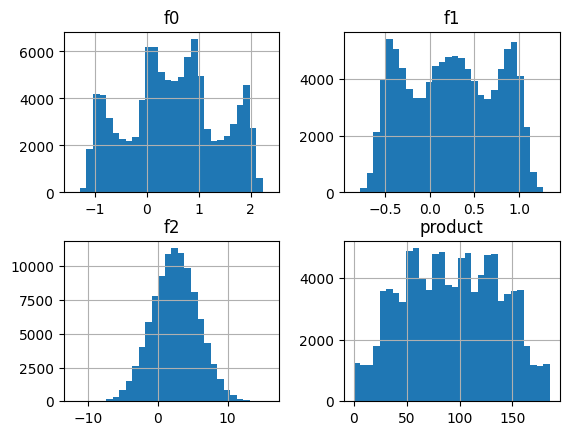

In [7]:
# 0 регион
data_0.hist(bins=30);

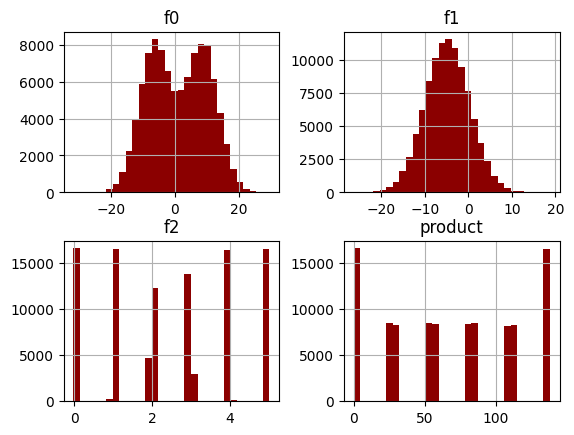

In [8]:
# 1 регион
data_1.hist(bins=30, color='darkred');

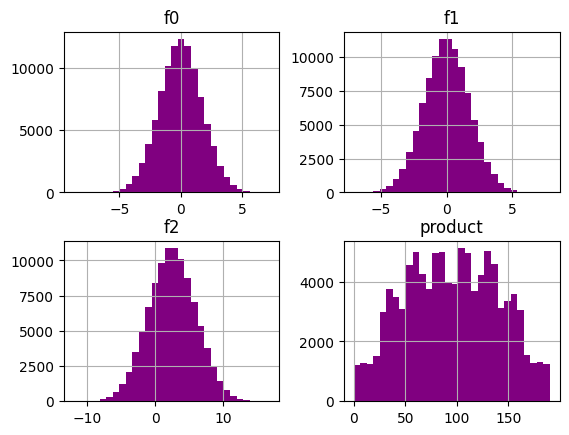

In [9]:
# 2 регион
data_2.hist(bins=30, color='purple');

**Диапазон значений в рамках одной таблицы примерно одинаковый для признаков. Можно было бы обойтись без стандартизации, но модель для исследования у нас LinearRegression, которая чувствительна к масштабированию. Сделаем стандартизацию на  всякий случай**

## Обучение и проверка модели

**Напишем функцию для разбивки на выборки, стандартизации и поиска RMSE**

In [10]:
pd.options.mode.chained_assignment = None

def repeating_func(data):
    #Определим признаки и целевой признак
    features = data.drop(['product'], axis=1)
    target = data['product']

    # Разбивка на объединенную и тестовую
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    # Масштабируем
    scaler = StandardScaler()
    scaler.fit(features_train) 
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)    
    
    # Обучите модель и сделайте предсказания на валидационной выборке.
    model = LinearRegression(n_jobs=-1)
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    predictions = pd.Series(data=predictions_valid, index=target_valid.index)
    # RMSE модели
    result = mean_squared_error(target_valid, predictions_valid)**0.5
    return predictions, result,  features_valid, target_valid 

### RMSE и средний запас предсказанного сырья для 0 региона

In [11]:
predictions_0, result_0,  f_v_0,  t_v_0  = repeating_func(data_0)
print('Cредний запас предсказанного сырья:', predictions_0.mean())
print('RMSE модели линейной регрессии на валидационной выборке:', result_0)

Cредний запас предсказанного сырья: 92.59256778438035
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


### RMSE и средний запас предсказанного сырья для 1 региона

In [12]:
predictions_1, result_1, f_v_1, t_v_1= repeating_func(data_1)
print('Cредний запас предсказанного сырья:', predictions_1.mean())
print('RMSE модели линейной регрессии на валидационной выборке:', result_1)

Cредний запас предсказанного сырья: 68.728546895446
RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617


### RMSE и средний запас предсказанного сырья для 2 региона

In [13]:
predictions_2, result_2, f_v_2, t_v_2 = repeating_func(data_2)
print('Cредний запас предсказанного сырья:', predictions_2.mean())
print('RMSE модели линейной регрессии на валидационной выборке:', result_2)

Cредний запас предсказанного сырья: 94.96504596800489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


### Вывод:

**Высокий средний запас продукта у 2 региона, но также у него самая худшая модель для предсказания. И наоборот лучшая модель у 1 региона с худшим показателем запаса.**

## Подготовка к расчёту прибыли

**Ведем константы для подсчета прибыли**

In [14]:
#Константы
BUDGET = 10**10
OIL_PRICE= 450000
BOREHOLES = 500
NEEDED_BOREHOLES = 200
LOSSES_PROBABILITY = 2.5

**Найдем средний запас продукта в регионе для безубыточной добычи.**

In [15]:
# Средний запас продукта в регионе для безубыточной добычи.
avg_for_region = BUDGET/(OIL_PRICE*NEEDED_BOREHOLES)
avg_for_region

111.11111111111111

**Вывод:**
Средний запас для безубыточной добычи 112 тыс.барр.

**Напишем функцию поиска прибыли в регионе**

In [16]:
def profit_sum(target, predictions):
    pred_sort = predictions.sort_values(ascending=False)
    top_200 = target[pred_sort.index][:NEEDED_BOREHOLES]
    product_volume = top_200.sum()
    profit = product_volume * OIL_PRICE- BUDGET
    return profit

In [17]:
print('Для 0 региона доход составит:', profit_sum(t_v_0, predictions_0))
print('Для 1 региона доход составит:', profit_sum(t_v_1, predictions_1))
print('Для 2 региона доход составит:', profit_sum(t_v_2, predictions_2))

Для 0 региона доход составит: 3320826043.1398506
Для 1 региона доход составит: 2415086696.681511
Для 2 региона доход составит: 2710349963.5998325


**Вывод: По предварительным данным лучшая прибыль у 0 региона. Но данные были нами искусственно отобраны, так как в  задаче указано что выборка берет случайные 500 значений и из них выбирает топ 200.**

## Расчёт прибыли и рисков 

**Найдем доверительный интервал прибыли и риск убытка для каждого региона**

In [18]:
state = np.random.RandomState(12345)

In [19]:
# Создадим функцию для бутстрапа.
def bootstrap_func(target, predictions):
    revenue = []
    for i in range(1000):
        target_subsample = target.sample(BOREHOLES, replace=True, random_state=state)
        
        pred_subsample = predictions[target_subsample.index] 
        revenue.append(profit_sum(target_subsample, pred_subsample))
    revenue = pd.Series(revenue)
    lower = revenue.quantile(0.025)      
    higher = revenue.quantile(0.975)
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), revenue, mean_revenue, risk)

### Доверительный интервал прибыли, прибыль и риск убытка для 0 региона

Доверительный интервал 95%: (-102090094.83793654, 947976353.3583689)
Возможная прибыль в регионе: 425938526
Риск убытка:6.0%
Риск убытка слишком велик


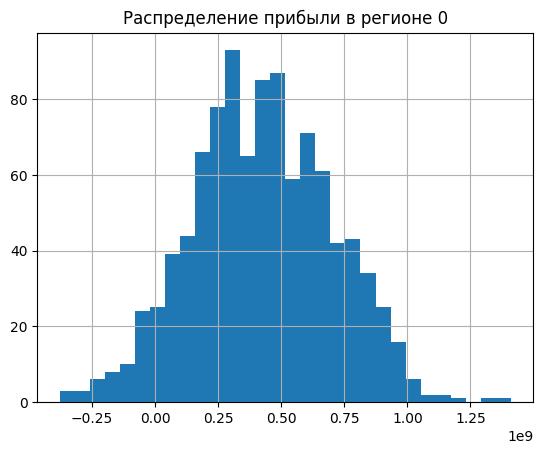

In [20]:
confidence_interval_0, revenue_0, profit_0, risk_0 = bootstrap_func(t_v_0, predictions_0)
plt.title('Распределение прибыли в регионе 0')

print('Доверительный интервал 95%:', confidence_interval_0)
print('Возможная прибыль в регионе:', profit_0)
print(f'Риск убытка:{risk_0}%' )
if risk_0 > LOSSES_PROBABILITY: 
    print('Риск убытка слишком велик')
else: 
    print('Рекомендуемый регион для инвестиций')
revenue_0.hist(bins=30);

### Доверительный интервал прибыли, прибыль и риск убытка для 1 региона

Доверительный интервал 95%: (128123231.43308444, 953612982.0669085)
Возможная прибыль в регионе: 518259493
Риск убытка:0.3%
Рекомендуемый регион для инвестиций


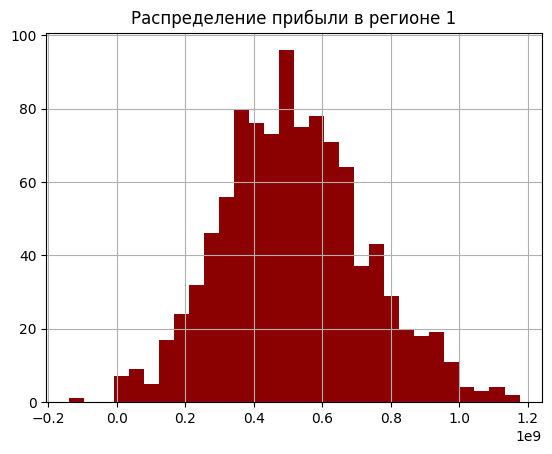

In [21]:
confidence_interval_1, revenue_1, profit_1, risk_1 = bootstrap_func(t_v_1, predictions_1)
plt.title('Распределение прибыли в регионе 1')

print('Доверительный интервал 95%:', confidence_interval_1)
print('Возможная прибыль в регионе:', profit_1)
print(f'Риск убытка:{risk_1}%' )
if risk_1> LOSSES_PROBABILITY: 
    print('Риск убытка слишком велик')
else: 
    print('Рекомендуемый регион для инвестиций')
revenue_1.hist(bins=30, color='darkred');

### Доверительный интервал прибыли, прибыль и риск убытка для 2 региона

Доверительный интервал 95%: (-115852609.16001143, 989629939.8445739)
Возможная прибыль в регионе: 420194005
Риск убытка:6.2%
Риск убытка слишком велик


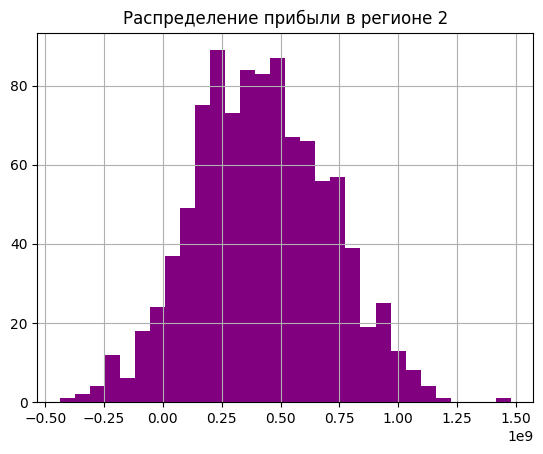

In [22]:
confidence_interval_2, revenue_2, profit_2, risk_2 = bootstrap_func(t_v_2, predictions_2)
plt.title('Распределение прибыли в регионе 2')

print('Доверительный интервал 95%:', confidence_interval_2)
print('Возможная прибыль в регионе:', profit_2)
print(f'Риск убытка:{risk_2}%' )
if risk_2 > LOSSES_PROBABILITY: 
    print('Риск убытка слишком велик')
else: 
    print('Рекомендуемый регион для инвестиций')
revenue_2.hist(bins=30, color='purple');

### Вывод:

**В ходе ииследования был найден 95% доверительный интервал прибыли, а также прибыль и риск убытков для каждого региона. На основе полученных результатов, самую большую прибыль 518259493, а также положительный интервал (128123231.43, 953612982.06)  и минимальный риск убытков 0.3% у первого региона.**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован